# Chapter 9: Time-Varying Volatility #

## Code segment 9.1  
Historical market volatility calculation in Section 9.1

In [2]:
#Code Segment 9.1
import matplotlib.pyplot as plt
%matplotlib inline
import qrpm_funcs as qf
import numpy as np
plt.rcParams['figure.dpi']= 300
#Find long-term standard deviation of US stock market
#Uses Ken French's website

#Cut off at last yearend
lastday=qf.LastYearEnd()
ld_yyyymm=int(lastday[:4]+lastday[5:7])
Date,market_minus_rf,SMB,HML,RF=qf.getFamaFrench3(enddate=ld_yyyymm)

ActualReality=qf.LogReturnConvert(market_minus_rf,RF)

#Compute overall monthly standard deviation
targetsd=np.std(ActualReality)

tstr='Annualized standard deviation of US stock market,\n'
tstr+=str(Date[0])[:6]+'-'+str(Date[len(Date)-1])[:6]
tstr+="(%.1f years)" % float(len(market_minus_rf)/12)
tstr+=': %.2f%%' % float(targetsd*np.sqrt(12))
print(tstr)

Annualized standard deviation of US stock market,
192607-202112(95.5 years): 18.42%


## Code segment 9.2  
Figure 9.1 in Section 9.1

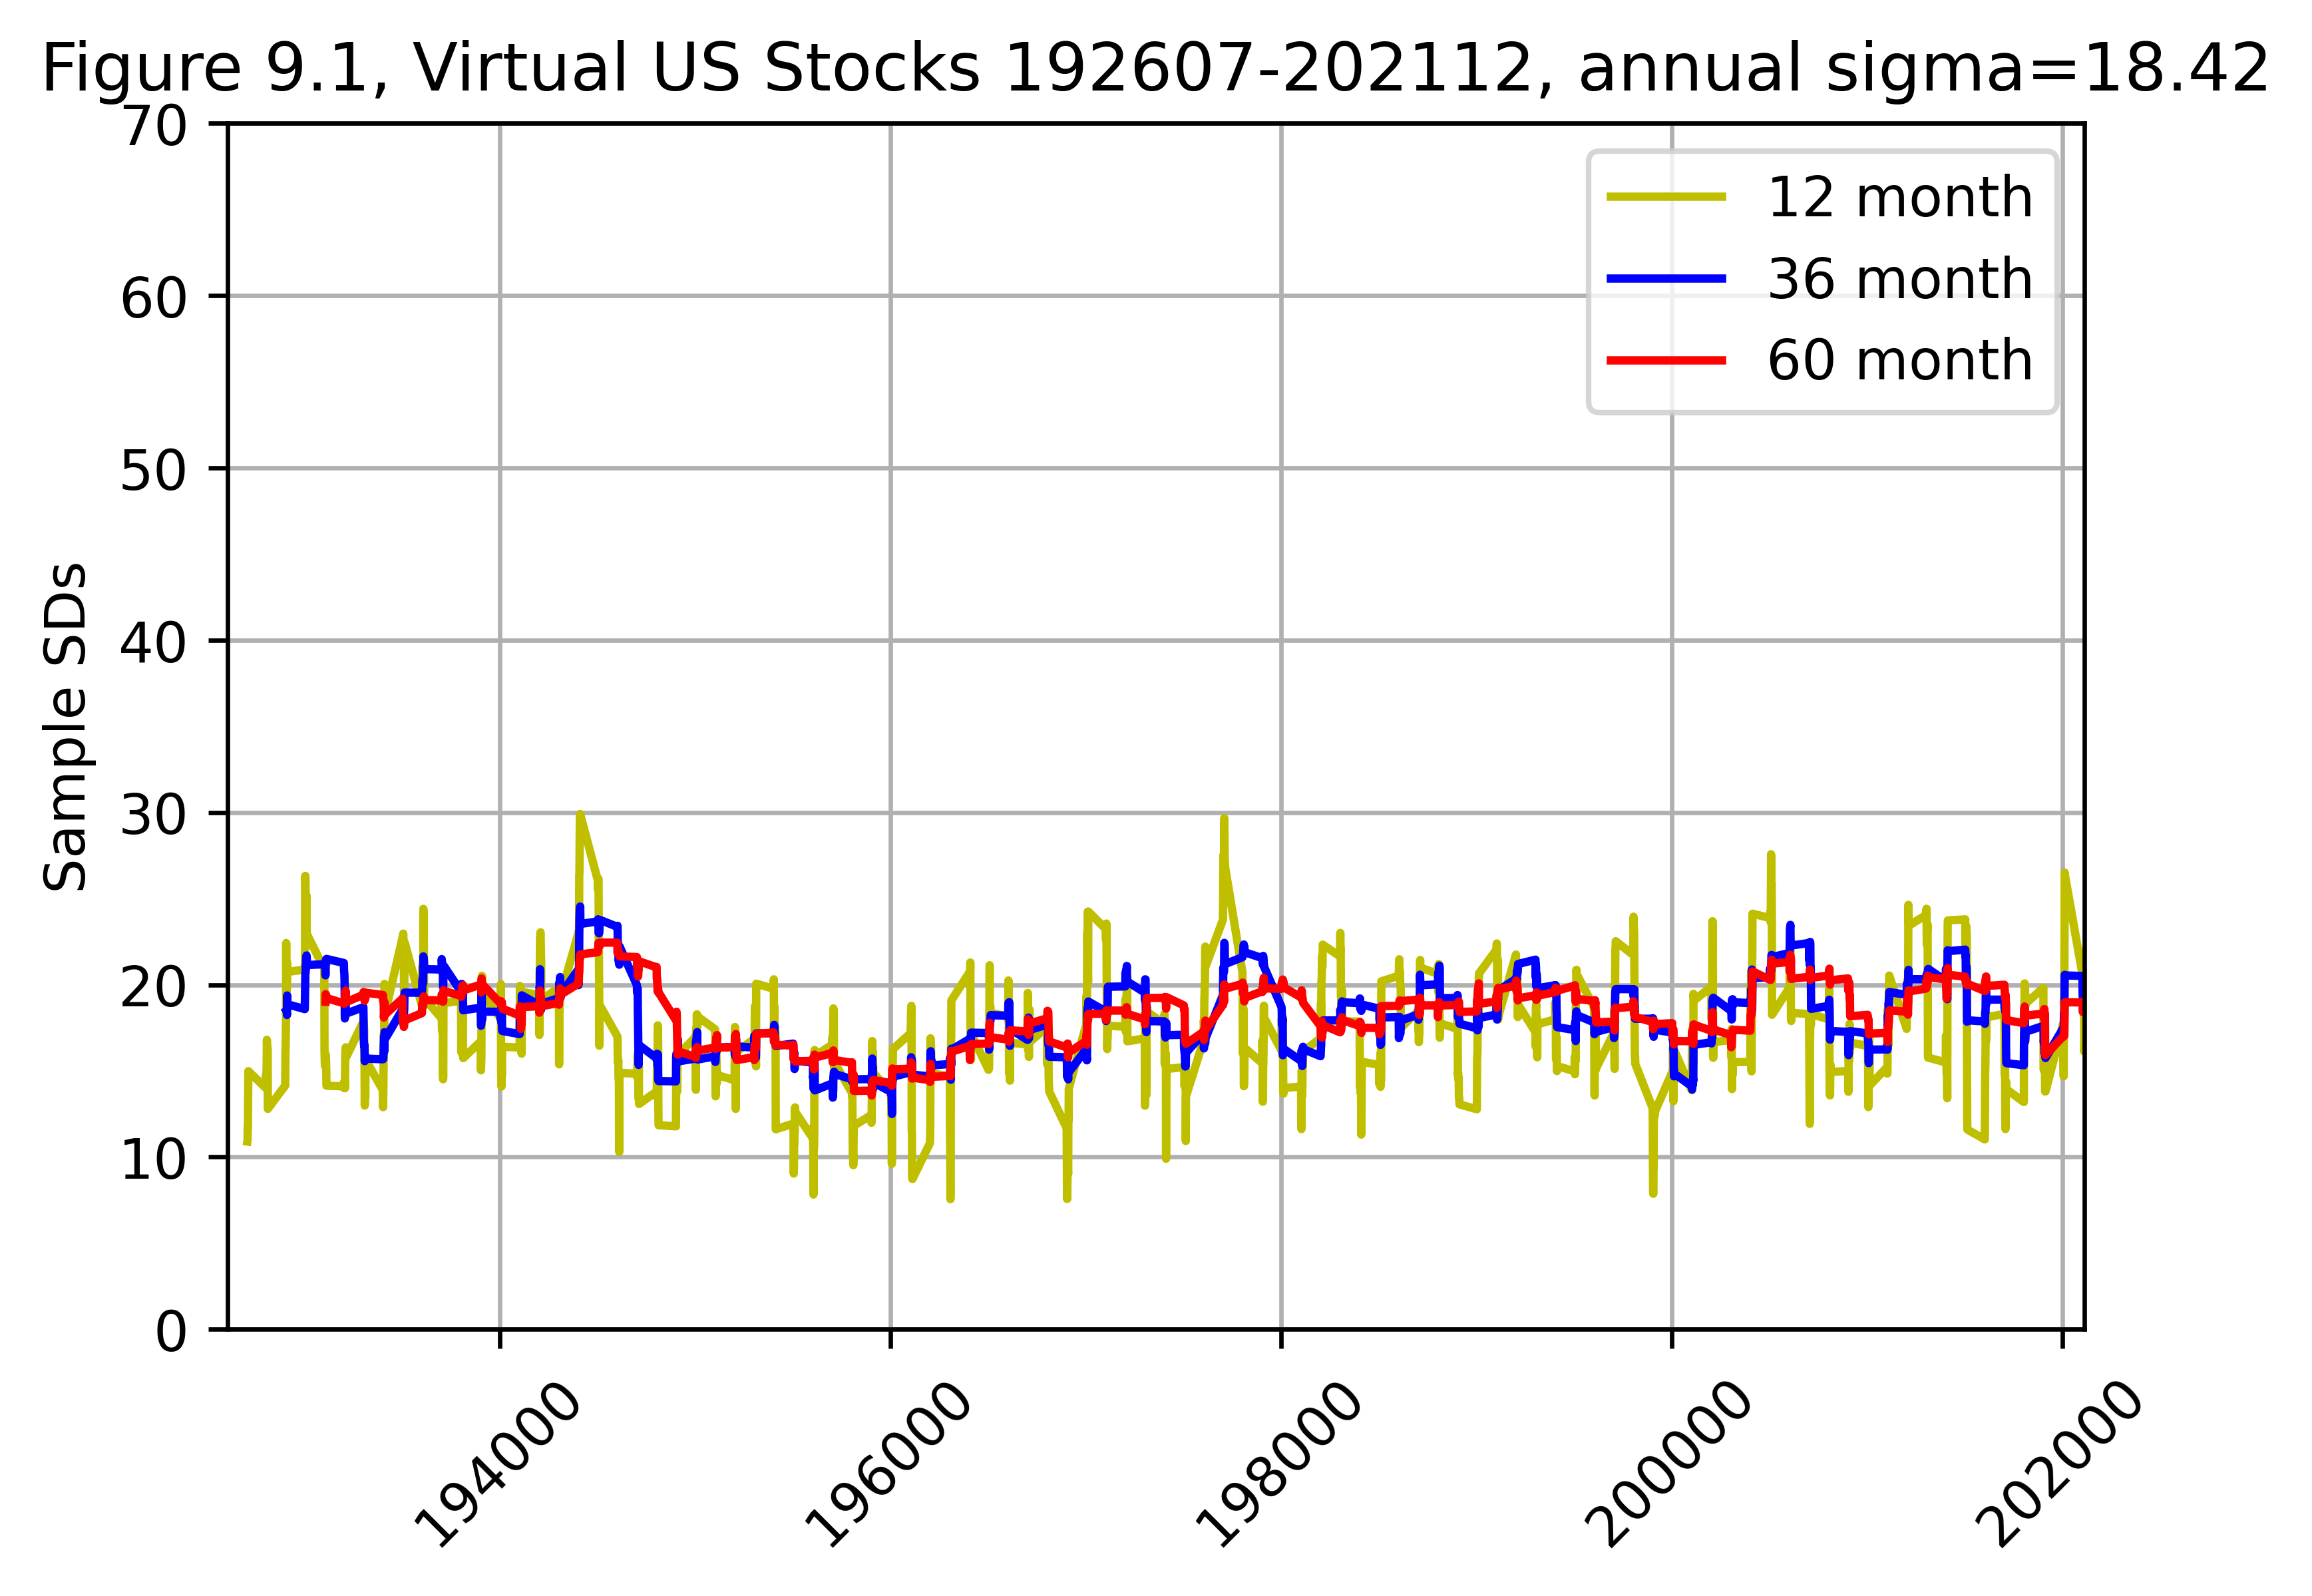

In [3]:
#Code Segment 9.2
#Generate virtual reality with random normal draws with targetsd
import random

random.seed(3.14159265)
VirtualReality=[random.gauss(0,targetsd) for i in range(len(ActualReality))]

#Generate sample standard deviations for 3 lookback periodicities
lookbacks=[12,36,60]
SampleSd=qf.GenSampleSd(VirtualReality,lookbacks)

#Draw the graph with 3 lines for the 3 periodicities
colors=['y-','b-','r-']
tstr='Figure 9.1, Virtual US Stocks '+str(Date[0])[:6]
tstr+='-'+str(Date[len(Date)-1])[:6]
tstr+=', annual sigma=%.2f' % float(targetsd*np.sqrt(12))
qf.PlotSampleSd(tstr,Date,SampleSd,lookbacks,colors)

## Code segment 9.3  
Figure 9.2 in Section 9.1

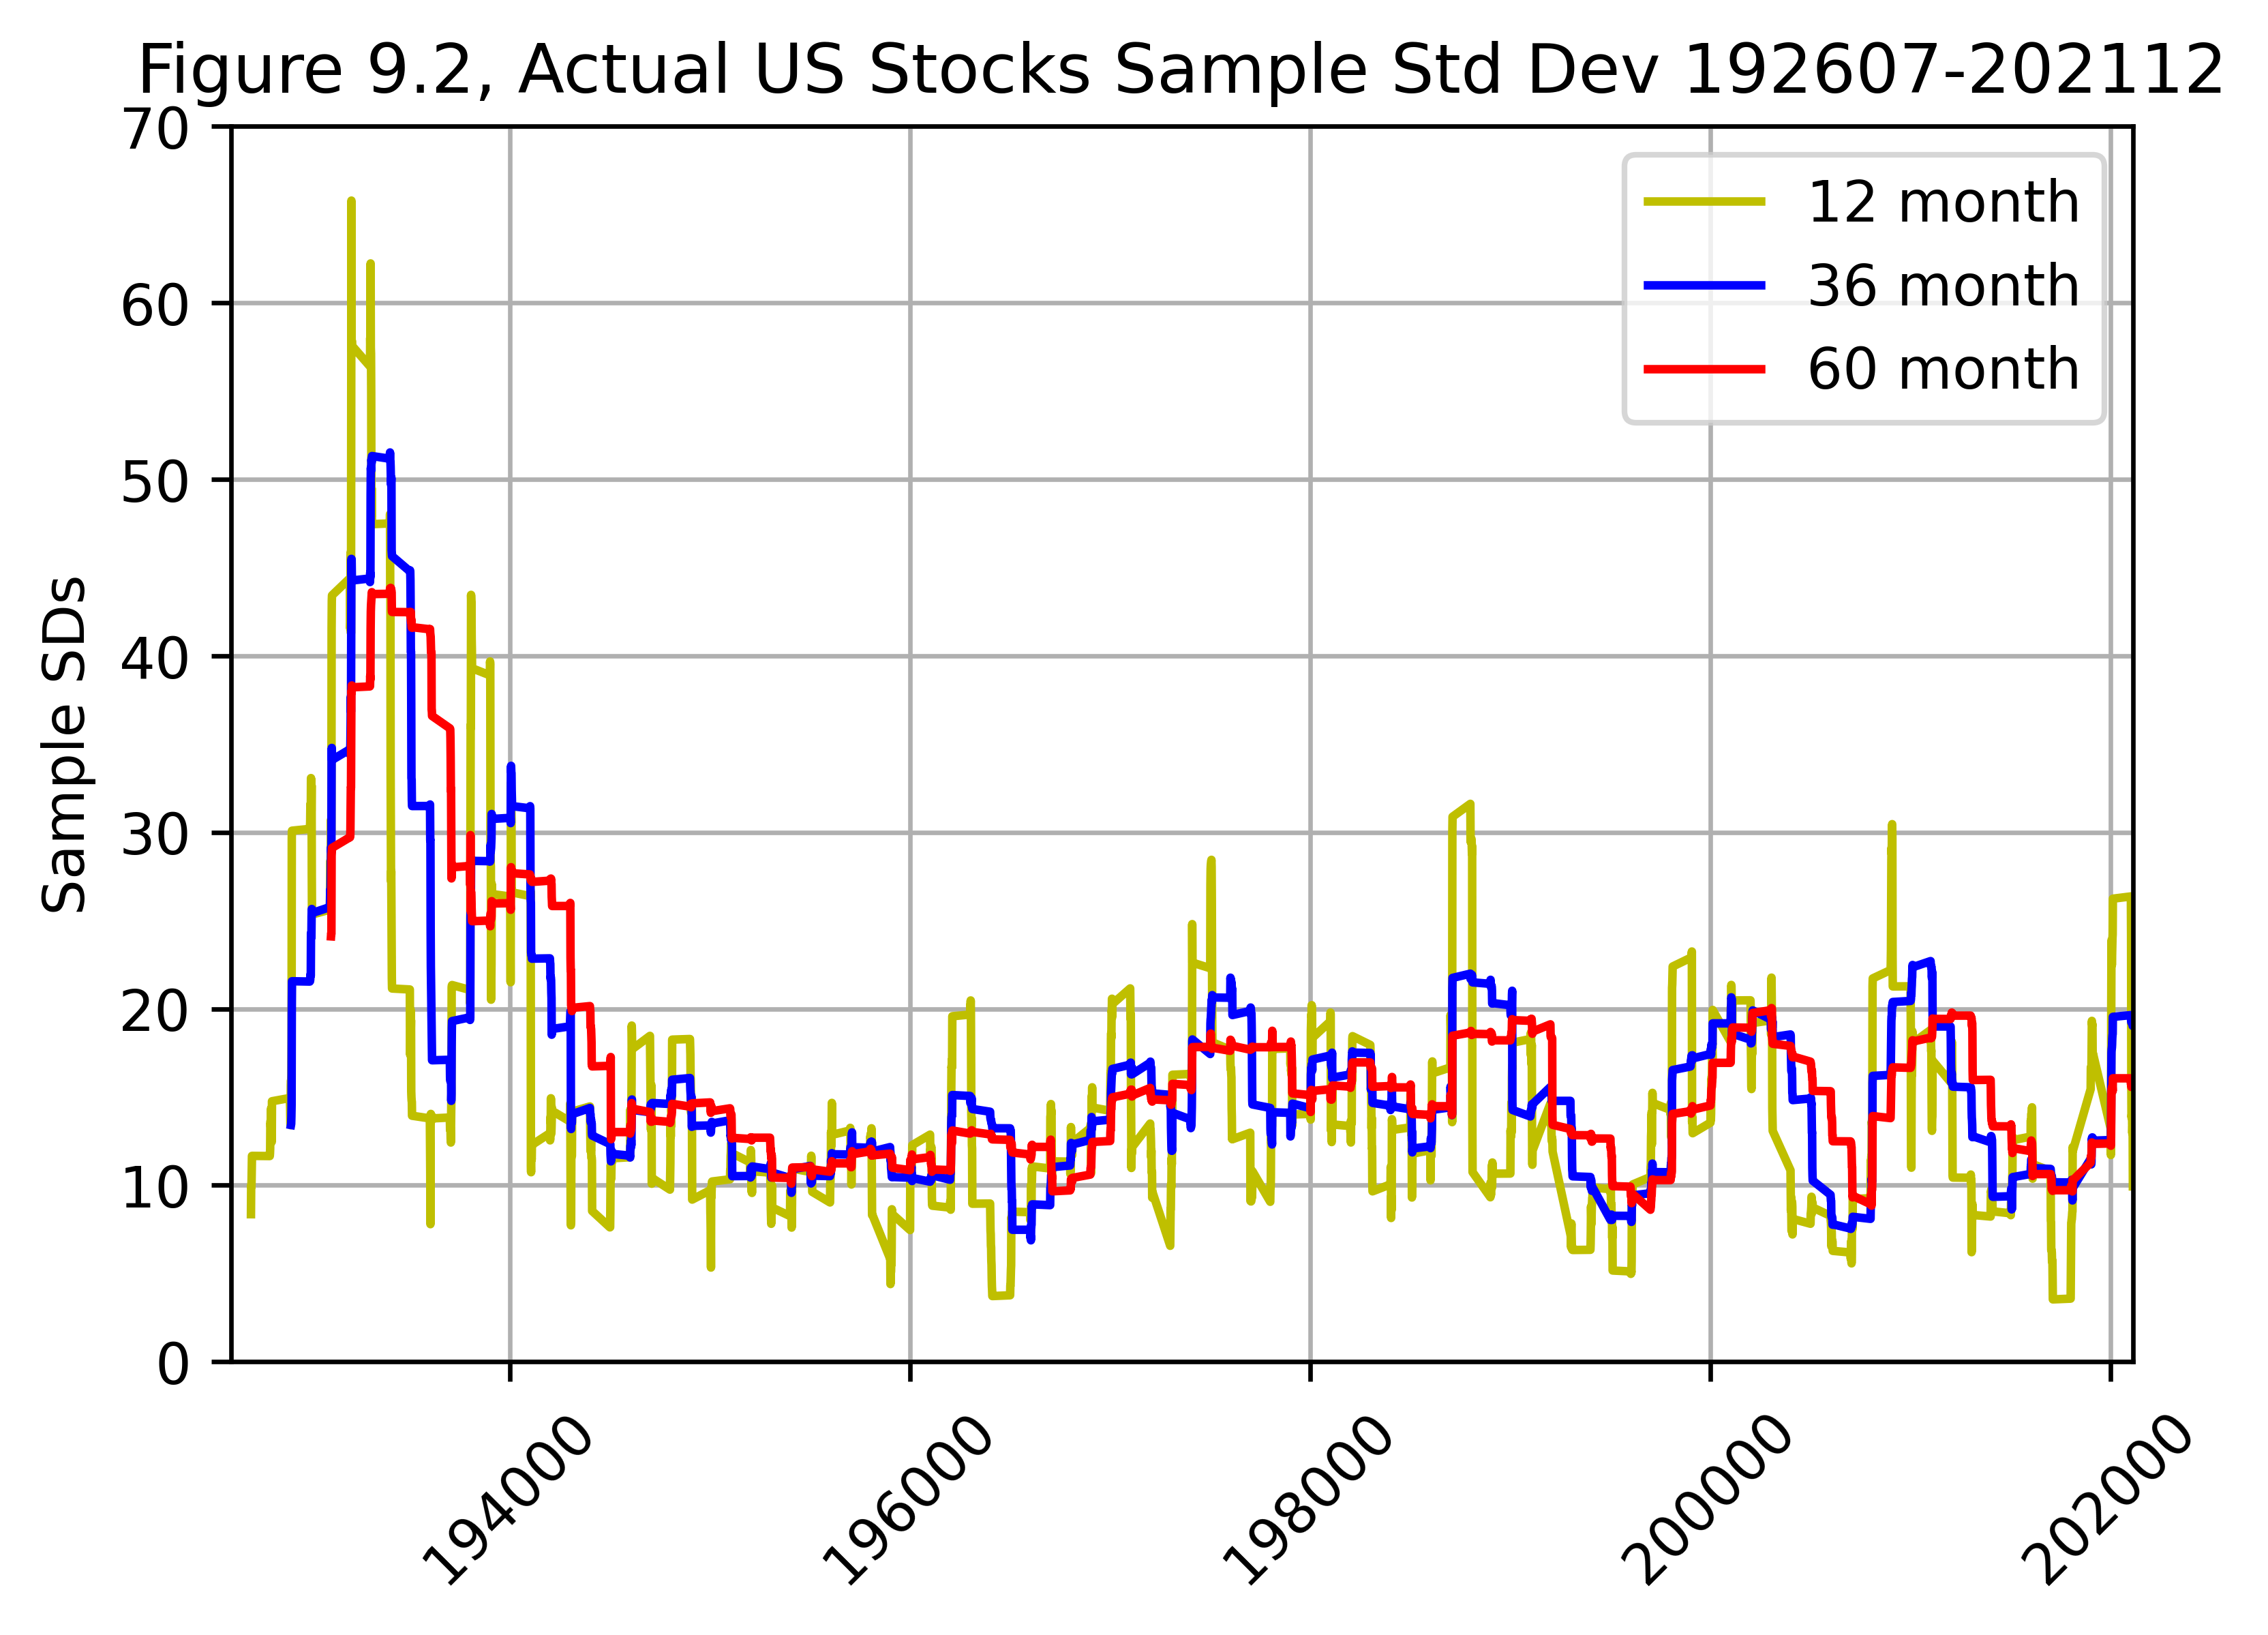

In [4]:
#Code Segment 9.3
#Generate sample standard deviations
lookbacks=[12,36,60]
SampleSd=qf.GenSampleSd(ActualReality,lookbacks)

#Graph
colors=['y-','b-','r-']
tstr='Figure 9.2, Actual US Stocks Sample Std Dev '+str(Date[0])[:6]
tstr+='-'+str(Date[len(Date)-1])[:6]
qf.PlotSampleSd(tstr,Date,SampleSd,lookbacks,colors)

## Code segment 9.4  
Figure 9.3 in Section 9.2.2

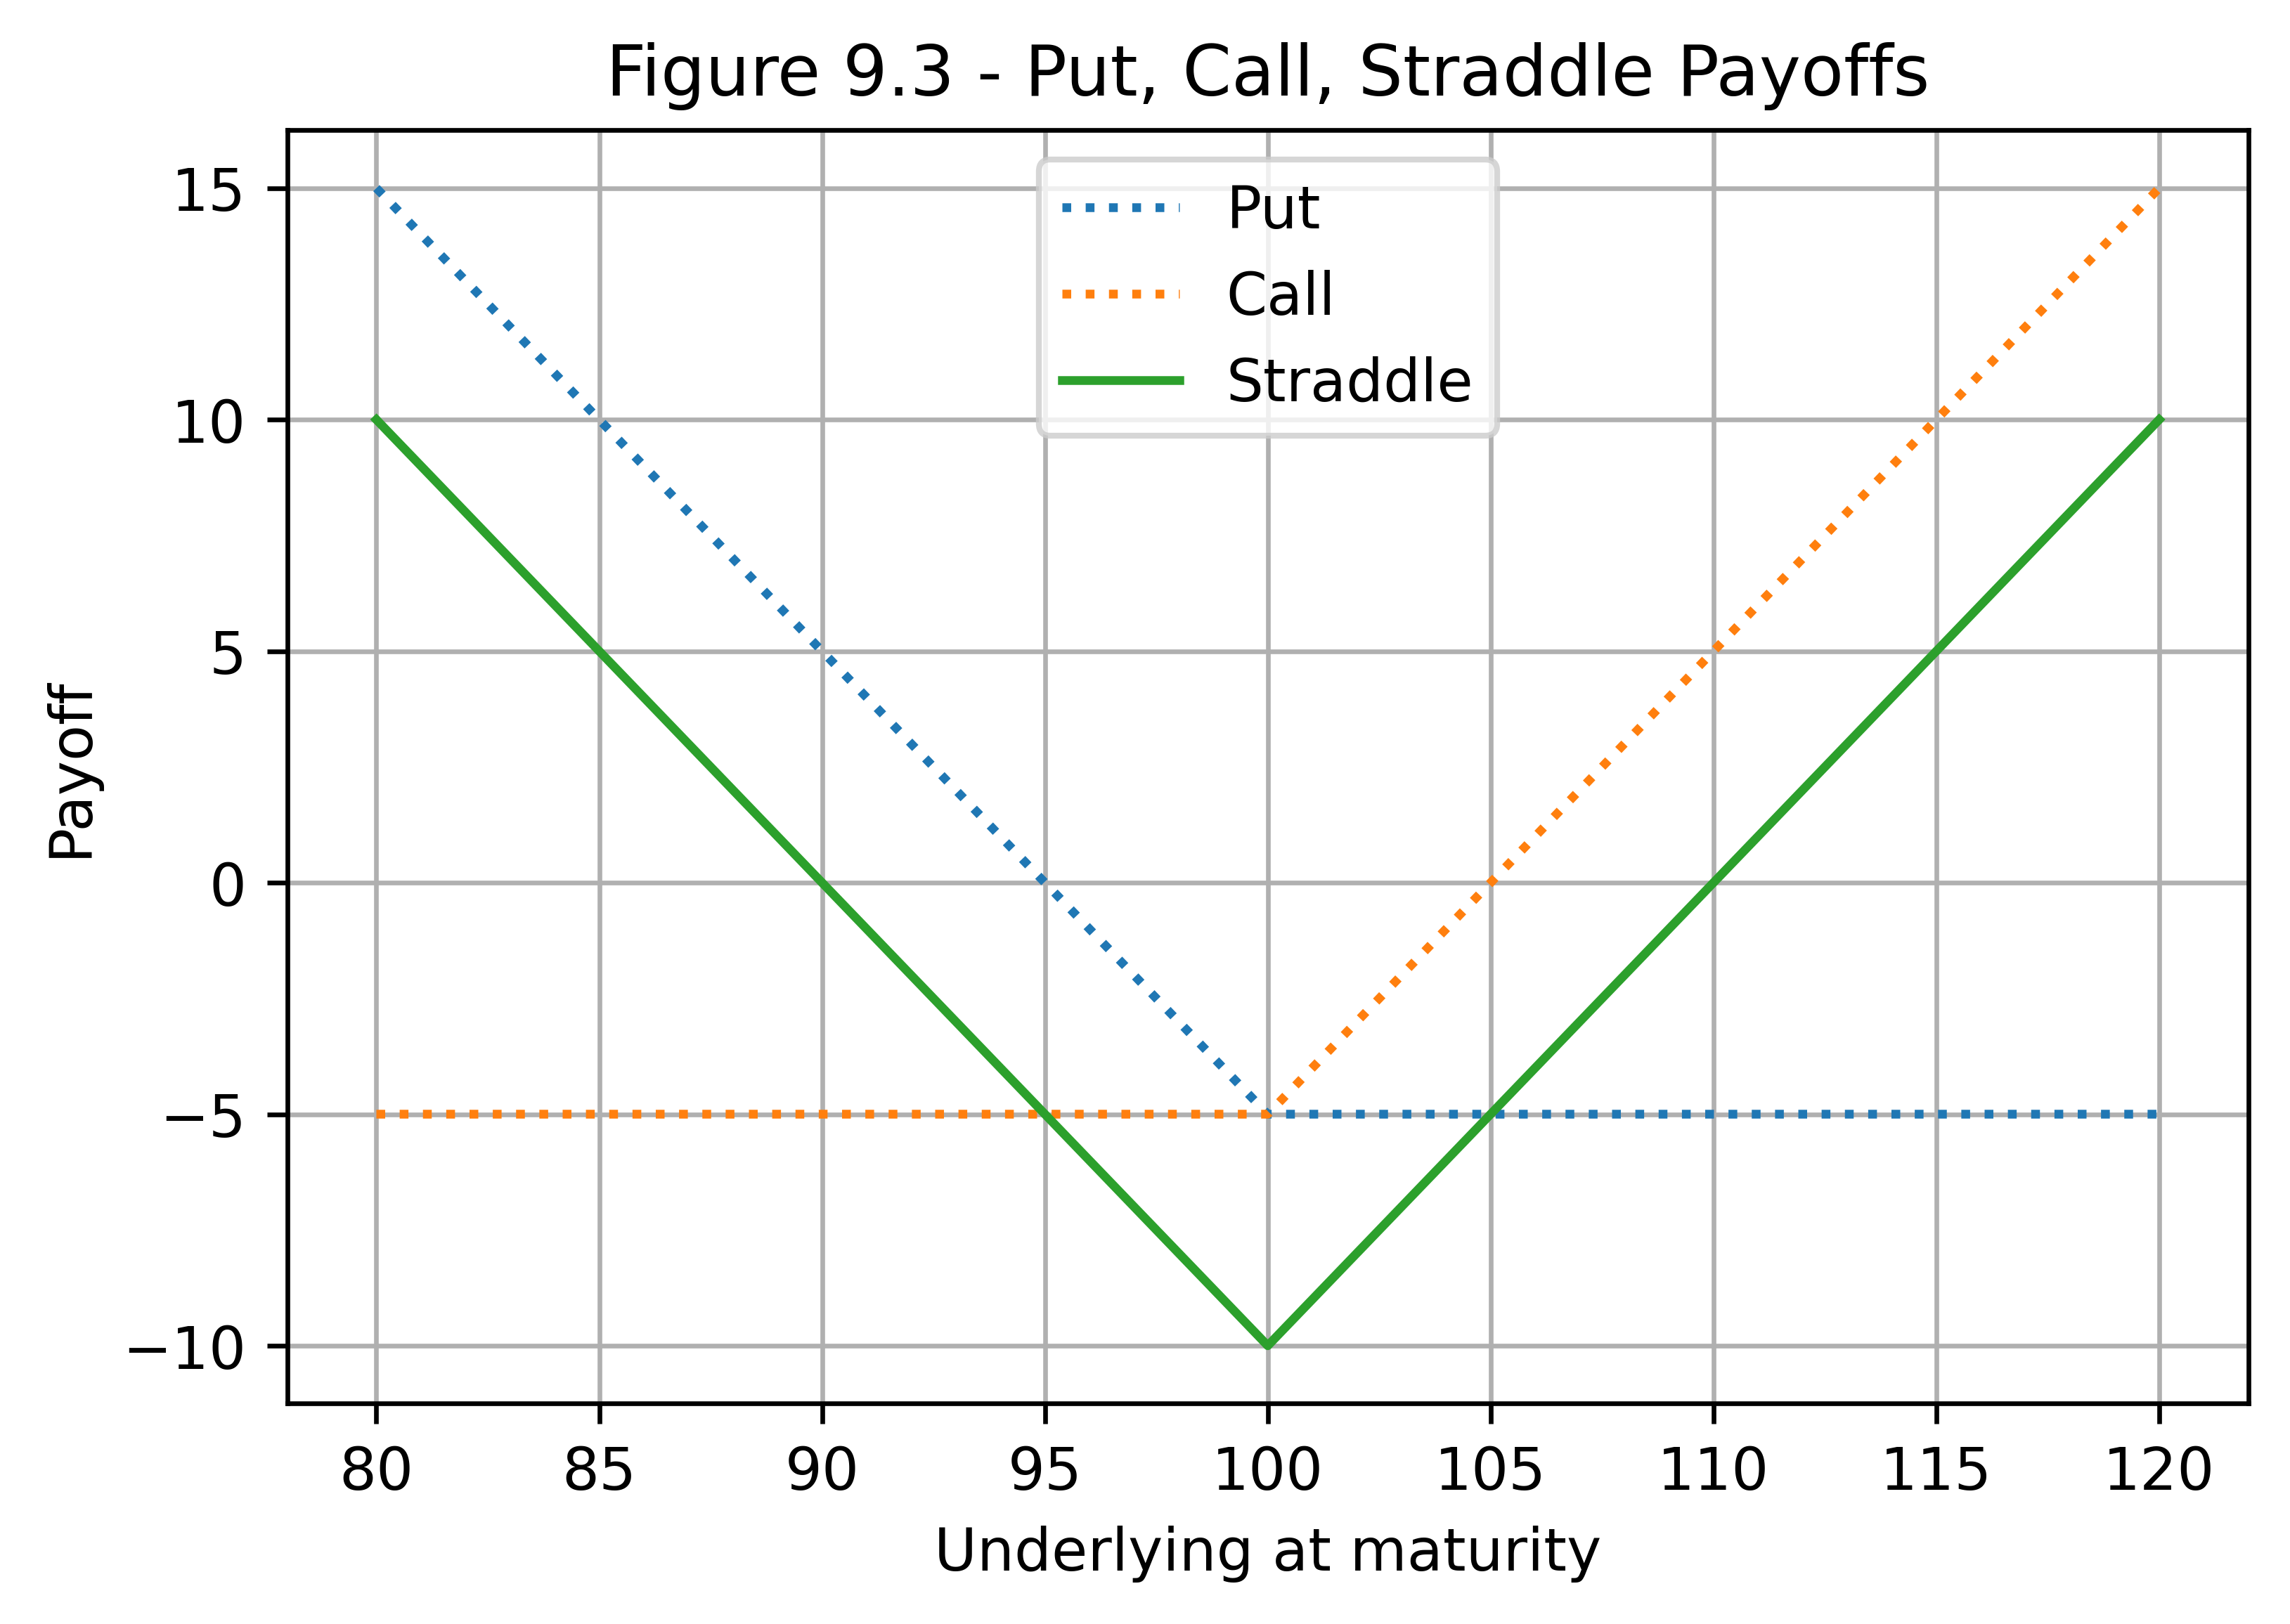

In [5]:
#Code Segment 9.4
import matplotlib.pyplot as plt
#Draw graph showing payoff pattern of put,
#call and straddle

underprices=np.arange(80,121,1)

strike=100
cost=5
putprices=np.maximum(strike-underprices,0)-cost
callprices=np.maximum(underprices-strike,0)-cost
straddleprices=putprices+callprices
        
plt.plot(underprices,putprices,label='Put',linestyle=':')
plt.plot(underprices,callprices,label='Call',linestyle=':')
plt.plot(underprices,straddleprices,label='Straddle')
plt.xlabel("Underlying at maturity")
plt.ylabel("Payoff")
plt.title('Figure 9.3 - Put, Call, Straddle Payoffs') 
plt.legend()
plt.grid()
plt.show()

## Code segment 9.5  
Figure 9.4 in Section 9.2.2

Dates of 10 largest
['1987-10-19', '1987-10-20', '1987-10-26', '1987-10-22', '1987-10-23', '1987-10-27', '2020-03-16', '2020-03-12', '2020-03-18', '2008-11-20']
Yearend VIX 17.22


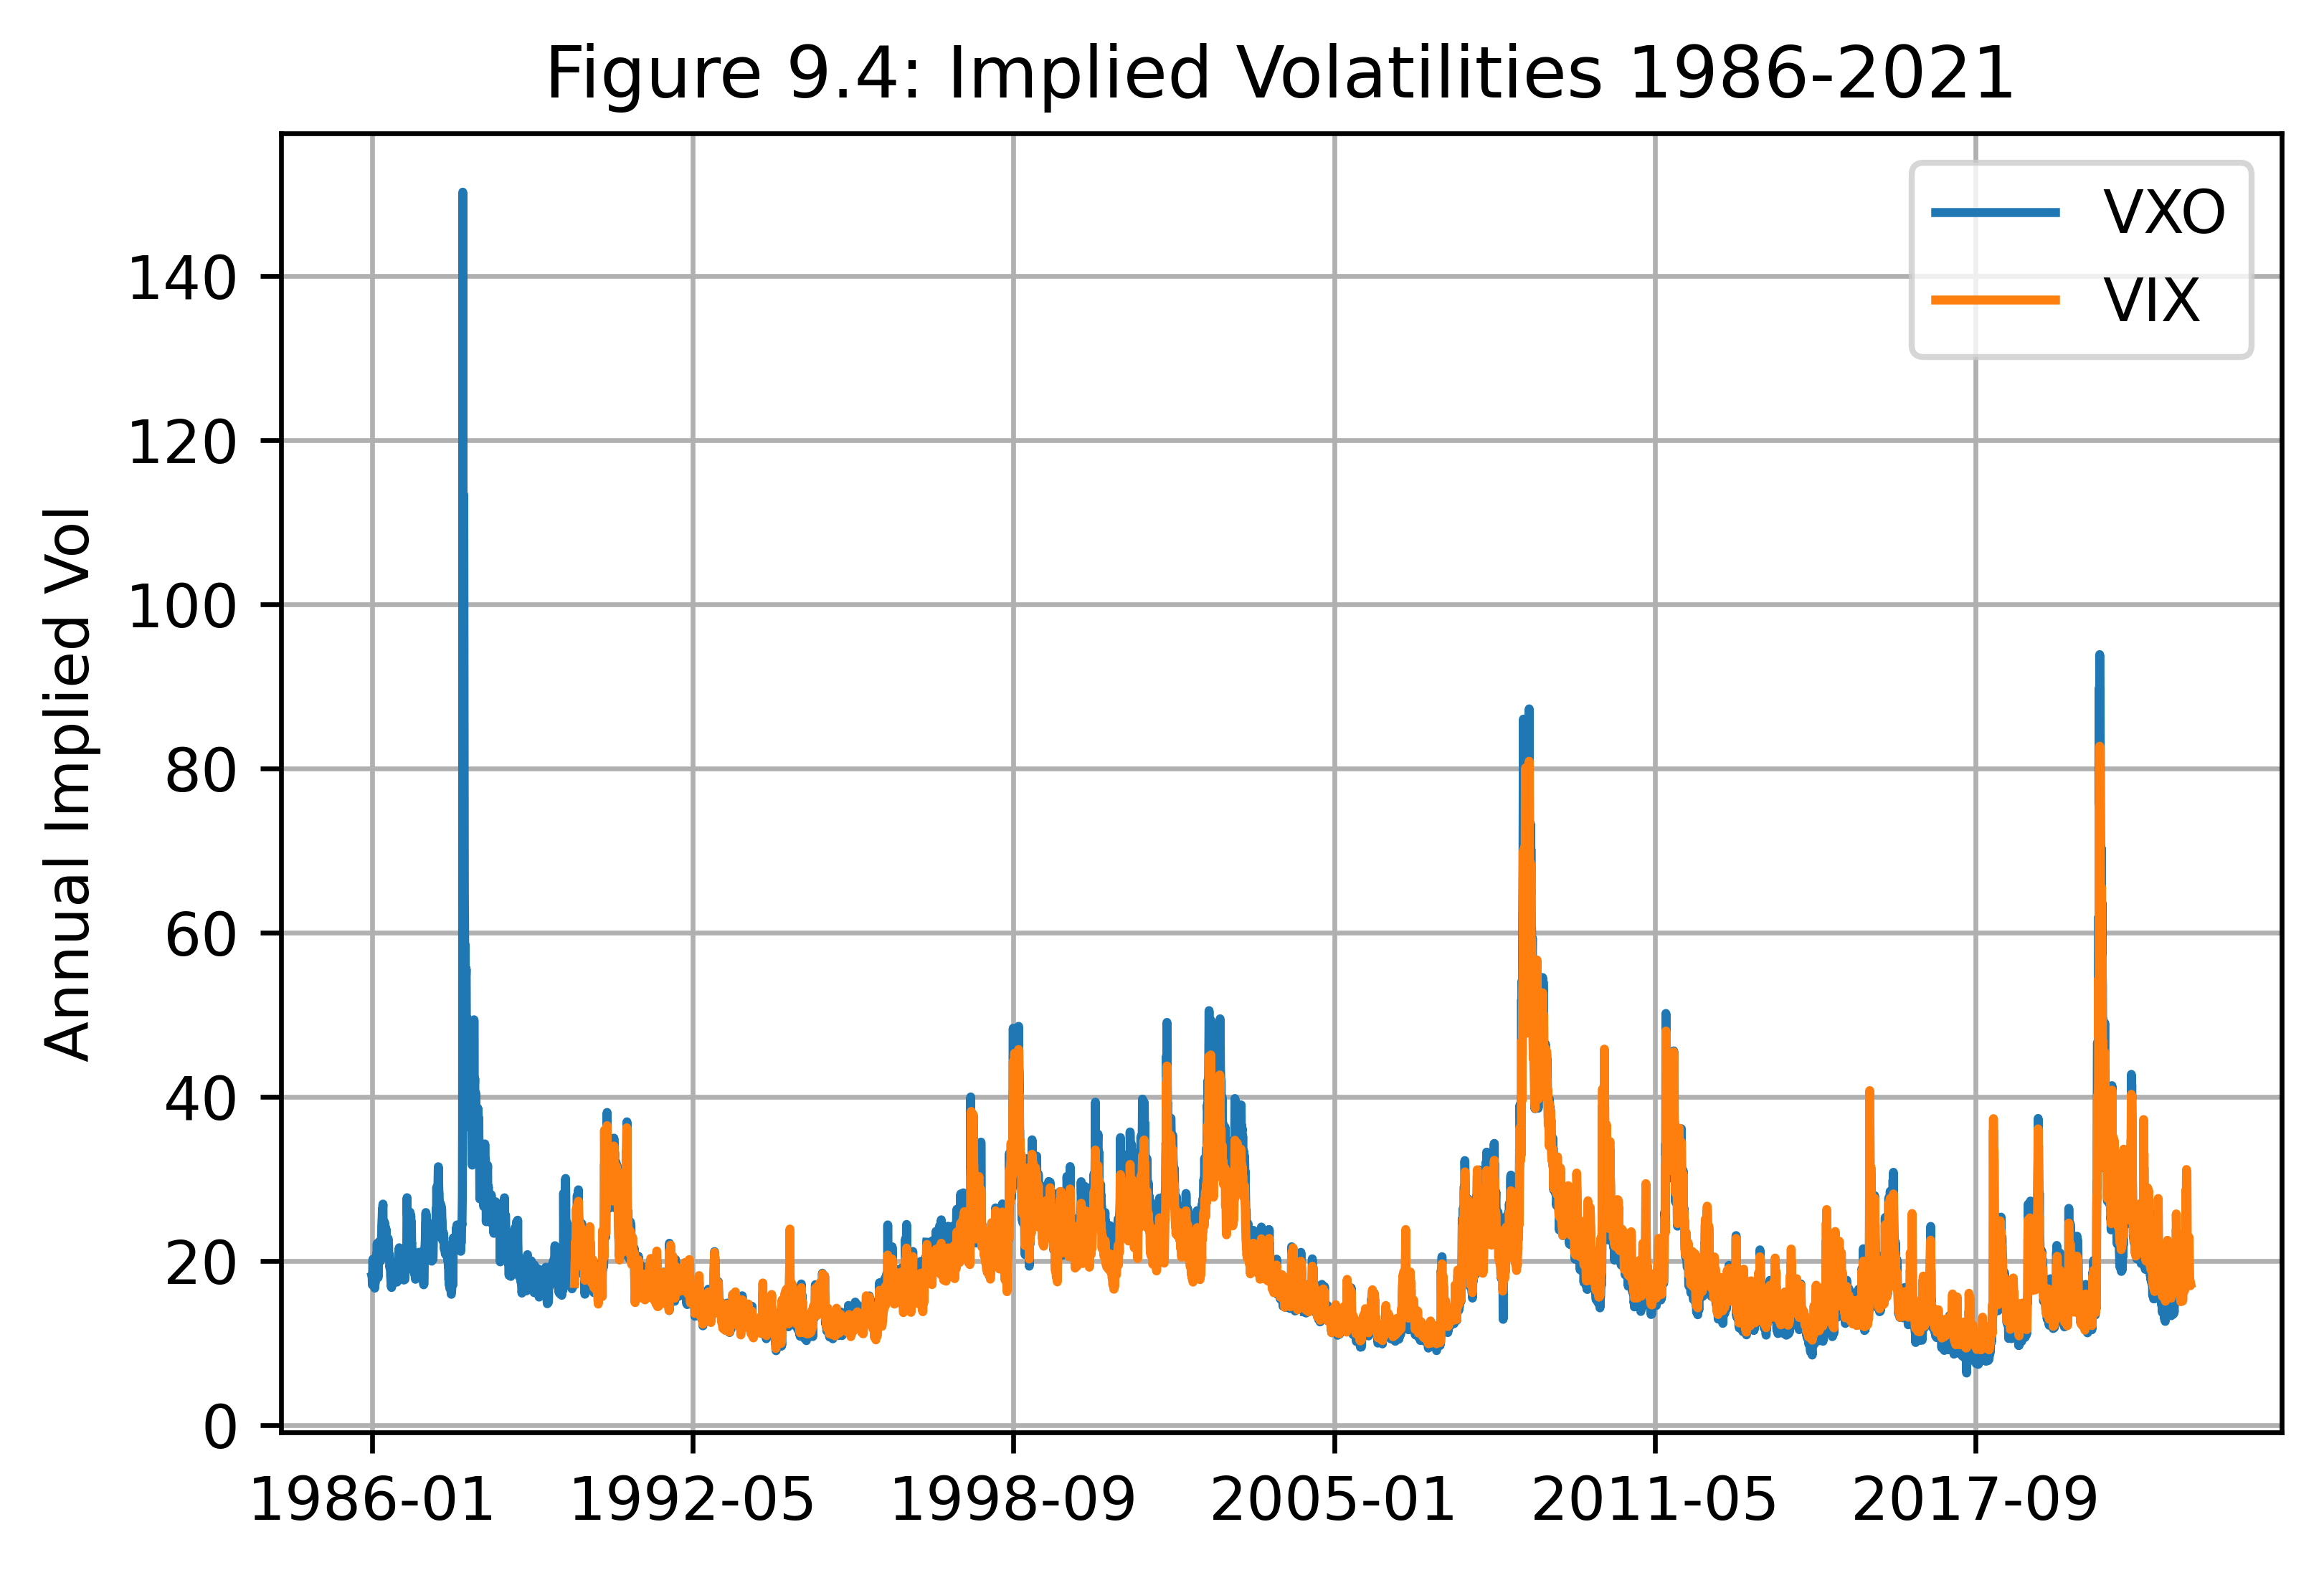

In [6]:
#Code Segment 9.5
import pandas as pd
#Get VXO and VIX from Fred and
#graph them.

lastday=qf.LastYearEnd()
seriesnames=['VXOCLS','VIXCLS']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,
            enddate=lastday)

#Get rid of double nan's
vols=[ratematrix[i] for i in range(len(ratematrix)) if pd.notna(ratematrix[i]).any()]
vdates=[cdates[i] for i in range(len(ratematrix)) if pd.notna(ratematrix[i]).any()]

#vols now has VXO and VIX data where at least
#one of them is present.
x=range(len(vdates))
vxo=[row[0] for row in vols]
vix=[row[1] for row in vols]
plt.plot(x,vxo,label='VXO')
plt.plot(x,vix,label='VIX')
plt.title('Figure 9.4: Implied Volatilities '+vdates[0][:4]+'-'+vdates[len(vdates)-1][:4])

xskip=np.arange(0,len(vdates),1600)
tikskip=[vdates[x][:7] for x in xskip]
plt.xticks(xskip,tikskip)
plt.ylabel('Annual Implied Vol')
plt.legend()
plt.grid()
plt.show;

#10 largest dates
import heapq
print("Dates of 10 largest")
print([vdates[x] for x in heapq.nlargest(10, range(len(vxo)), key=vxo.__getitem__)])
#Yearend VIX
print("Yearend VIX",vix[-1])

## Code segment 9.6  
Figure 9.5 in Section 9.2.3

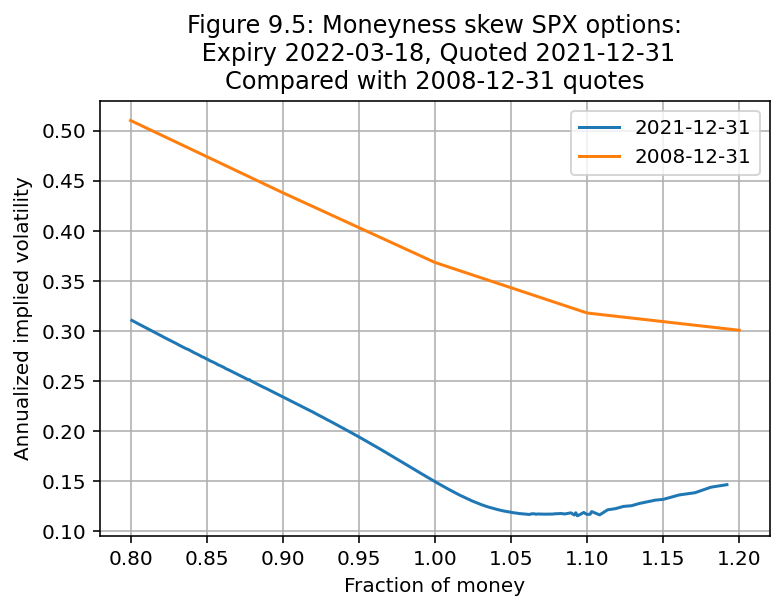

In [7]:
#Code Segment 9.6
#Draw implied vols on two dates by moneyness
#Use downloaded file YYYY-12-31 from CBOE with all option prices on that day
#The full file takes a LONG time to read in.
#Separate code needs to be run once a year before this code segment; it
#is in Process_CBOE_file.ipynb and reads in file from CBOE datashop and
#outputs SPX_UnderlyingOptionsEODCalcs_YYYY1231.xlsx.

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

#Get all SPX options on CBOE as of December 31 of last year
yearend_string=qf.LastYearEnd()
df_opts=pd.read_excel(r"SPX_UnderlyingOptionsEODCalcs_"+yearend_string+".xlsx", \
                     engine="openpyxl")

#Subset the S&P 500 options with underlying SPX (eliminate SPXW, weekly expirations)
df_spx = df_opts[(df_opts.underlying_symbol == "^SPX") & (df_opts.root == "SPX")]

#Get S&P 500 price and quote date
spx_price = df_spx.active_underlying_price_1545.unique()[0]
quote_date = df_spx.quote_date.unique()[0]
stqd = str(quote_date)[:10]    #Display version YYYY-MM-DD

#Look between 80% of the money and 120% of the money
df_spx=df_spx[(df_spx.strike > .8*spx_price) & (df_spx.strike < 1.2*spx_price)]

#Eliminate expirations less than a week
df_spx=df_spx[df_spx.expiration>quote_date+np.timedelta64(6,'D')]

#Show strike skew of March options
df_60to90=df_spx[(df_spx.expiration>quote_date+np.timedelta64(60,'D')) & \
                 (df_spx.expiration<quote_date+np.timedelta64(90,'D'))]

strikes=[strike/spx_price for strike in df_60to90.strike.unique()]
implieds=[np.average(df_60to90[df_60to90.strike==strike].implied_volatility_1545) \
         for strike in df_60to90.strike.unique()]
sm1=[abs(str-1.) for str in strikes]
spx_ATM_60to90_implied = implieds[sm1.index(min(sm1))]

str_exp=df_60to90.expiration.iloc[0].strftime('%Y-%m-%d')
plt.plot(strikes,implieds,label=stqd)

#Add December 2008 graph
moneyness=[.8,.9,1.,1.1,1.2] 
imp2008=[0.510000164, 0.437931821, \
         0.368329438,0.31789782,0.30067243]
plt.plot(moneyness,imp2008,label='2008-12-31')

plt.xlabel("Fraction of money")
plt.ylabel("Annualized implied volatility")
plt.legend()
plt.grid()
str_title="Figure 9.5: Moneyness skew SPX options:\n Expiry "+str_exp+ \
    ", Quoted "+stqd
str_title+="\nCompared with 2008-12-31 quotes"
plt.title(str_title)
plt.show()

## Code segment 9.7  
Figure 9.6 in Section 9.2.3

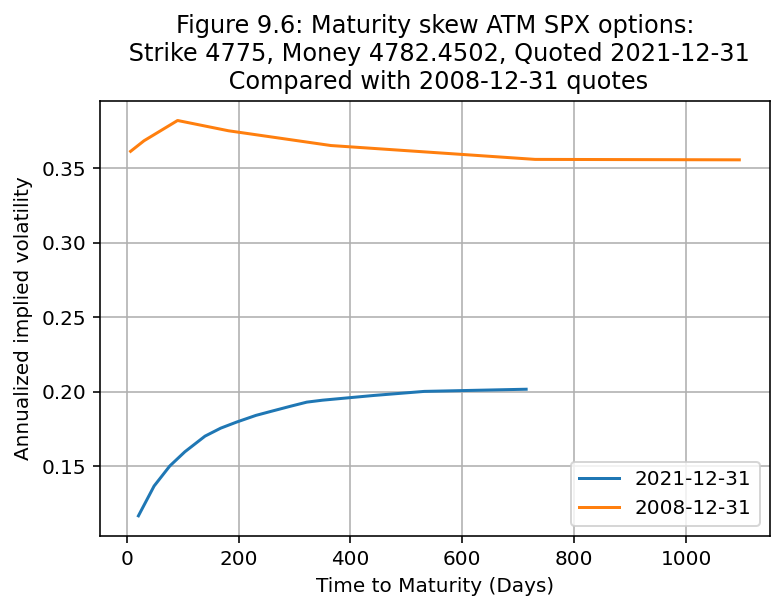

In [8]:
#Code Segment 9.7
#Get time skew of ATM options
#Find closest to the money
min_to_money = min(abs(df_spx.strike.unique()-spx_price))
df_ATM=df_spx[abs(df_spx.strike-spx_price)<=min_to_money+5]

times=[int((time-quote_date)/np.timedelta64(1,"D")) for time in df_ATM.expiration.unique()]
implieds=[np.average(df_ATM[df_ATM.expiration==time].implied_volatility_1545) \
         for time in df_ATM.expiration.unique()]

#plt.plot(range(len(times)),implieds,label=stqd)
plt.plot(times,implieds,label=stqd)

#Add 2008-12-31 data
expiry=[7,31,91,182,365,730,1095] 
imp2008=[.3612,.3683,.3819,.3750, \
         .3651,.3558,.3555]
plt.plot(expiry,imp2008,label='2008-12-31')

plt.xlabel("Time to Maturity (Days)")
plt.ylabel("Annualized implied volatility")
plt.grid()
plt.legend()
str_strike=str(df_ATM.strike.iloc[0])
str_title="Figure 9.6: Maturity skew ATM SPX options:\n Strike "+str_strike
str_title+=", Money "+str(spx_price)+", Quoted "+stqd
str_title+="\n Compared with 2008-12-31 quotes"
plt.title(str_title)
plt.show();

## Code segment 9.8  
Figures 9.7a and 9.7b in Section 9.2.3

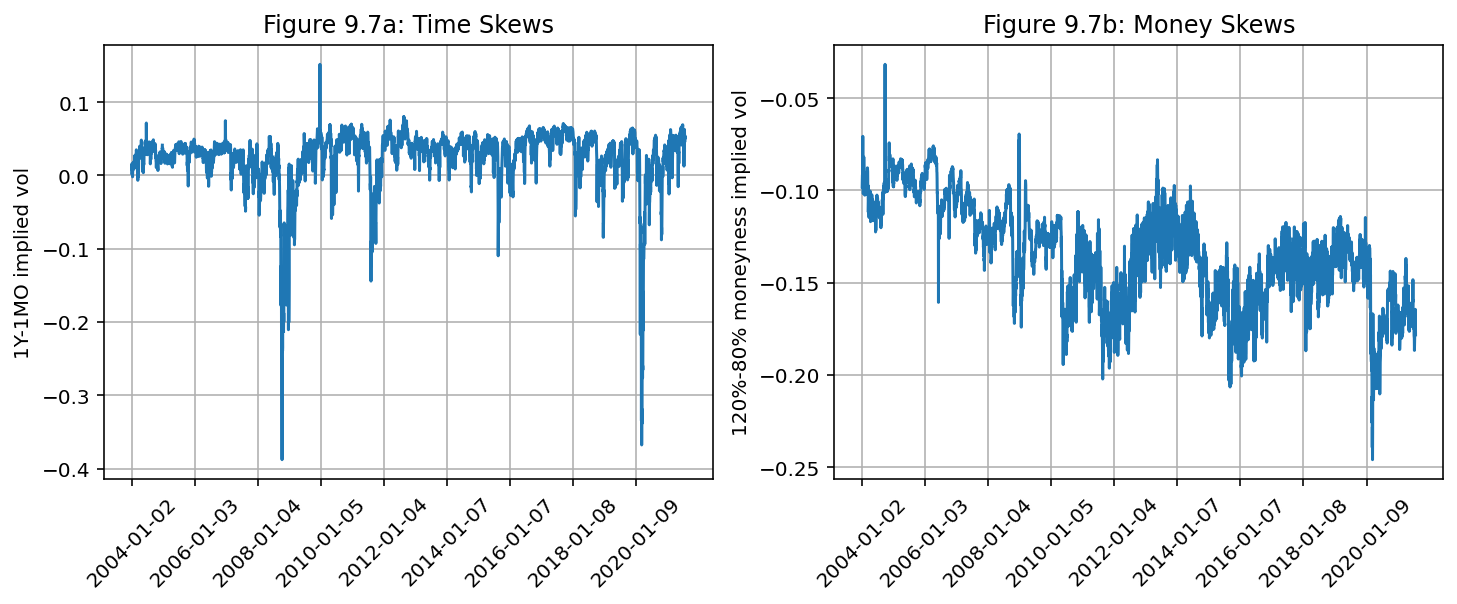

Percent time skew positive: 86.19%
Source: CBOE Datashop


In [9]:
#Code Segment 9.8
import pandas as pd
import matplotlib.pyplot as plt
#Read time series of implied vol skews
#from csv file and graph them (time and
#moneyness skews)

df_skew=pd.read_csv('IV_skews.csv')
#skip daily info
stride=504
x=range(len(df_skew))

#Graph time and money skews side by side
plt.figure(figsize=(12,4))

#Time skew
#correct error
df_skew.loc[df_skew.index[df_skew.Time_skew>.4][0],"Time_skew"]=float("nan")

plt.subplot(1,2,1)
plt.plot(x,df_skew.Time_skew)
plt.ylabel("1Y-1MO implied vol")
plt.xticks(range(0,len(df_skew),stride),df_skew.iloc[::stride].Date,rotation=45)
plt.grid()
plt.title('Figure 9.7a: Time Skews')

#Moneyness skew
#Moneyness skew was determined by taking all options with maturities
#between 90 and 360 days, and moneyness between (.7 and .9) on the low
#side, and (1.1 and 1.3) on the high side. Then implied volatilities were
#weighted by a metric that gives more weight to options closer to the targets
#(.8,180) and (1.2, 180), and averaged.
plt.subplot(1,2,2)
plt.plot(x,df_skew.Money_skew)
plt.ylabel("120%-80% moneyness implied vol")
plt.xticks(range(0,len(df_skew),stride),df_skew.iloc[::stride].Date,rotation=45)
plt.grid()
plt.title('Figure 9.7b: Money Skews')
    
plt.show();

n_time_pos=len(df_skew[df_skew.Time_skew>0])
print("Percent time skew positive: {:.2f}%".format(100.*n_time_pos/len(df_skew)))
print("Source: CBOE Datashop")

## Code segment 9.9  
Figure 9.8 in Section 9.3.5

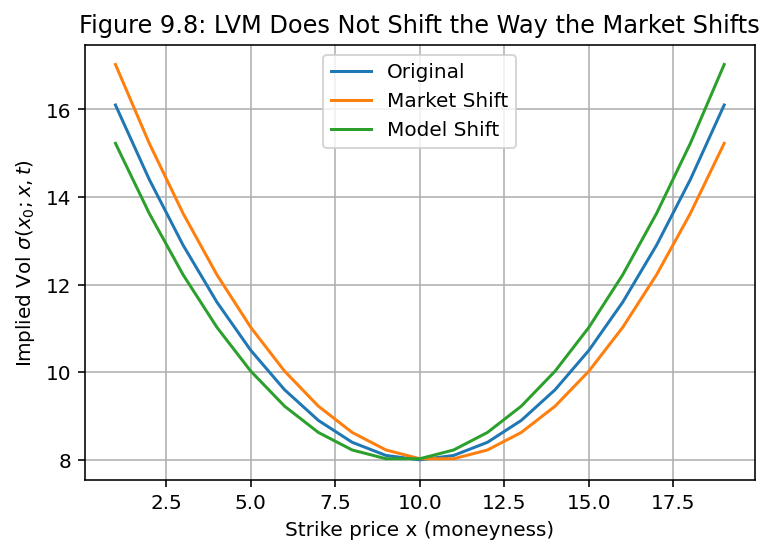

In [10]:
#Code Segment 9.9
#Draw two smiles illustrating problem
#with LVM vs Market

strikes=np.arange(1,20)
original=[(s-10)**2/10+8 for s in strikes]
mktshift=[(s-.5-10)**2/10+8 for s in strikes]
modelshift=[(s+.5-10)**2/10+8 for s in strikes]

plt.plot(strikes,original,label='Original')
plt.plot(strikes,mktshift,label='Market Shift')
plt.plot(strikes,modelshift,label='Model Shift')

plt.ylabel('Implied Vol '+r'$\sigma(x_0;x,t)$')
plt.xlabel('Strike price x (moneyness)')
plt.grid()
plt.legend()
plt.title('Figure 9.8: LVM Does Not Shift the Way the Market Shifts')
plt.show()

## Code segment 9.10  
Figure 9.9 in Section 9.3.6

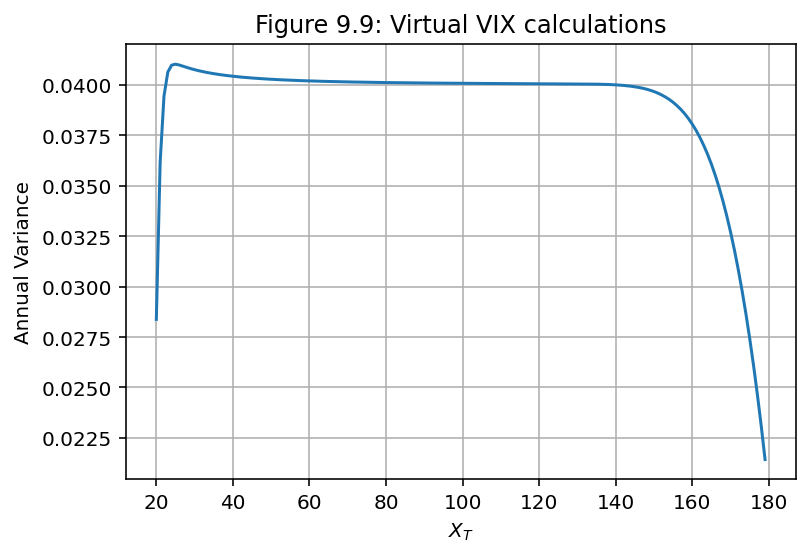

In [11]:
#Code Segment 9.10
#compute pseudo-VIX at different underlying prices
import scipy.stats as spst

def black_scholes_call(under,strike,time,rfree,vol):
    #Formula 9.3 - returns price of call
    if under<=0 or strike<=0 or time<=0 or vol<0:
        return(0)
    d_1=(np.log(under/strike)+(rfree+vol**2/2)*time)/(vol*np.sqrt(time))
    d_2=d_1-vol*np.sqrt(time)
    call_val=under*spst.norm.cdf(d_1)-strike*np.exp(-rfree*time)*spst.norm.cdf(d_2)
    return(call_val)
#done with black_scholes_call

def black_scholes_put(under,strike,time,rfree,vol):
    #use put-call parity (9.1)
    return(black_scholes_call(under,strike,time,rfree,vol)- \
           under+np.exp(-rfree*time)*strike)
#done with black_scholes_put
    
r=0; T=.25; sigma=.2; delta_K=1
X_list=np.arange(20,180,1)
K_list=np.arange(20,180,delta_K)
z=[]
for X in X_list:
    K_0=np.exp(r*T)*X   #use forward price as divider between puts and calls
                        #so no adjustment needed
    yy=0
    for K in K_list:
        if K<=K_0: #Puts are used below the divider
            y=black_scholes_put(X,K,T,r,sigma)
        else: #Calls are used above the divider
            y=black_scholes_call(X,K,T,r,sigma)
        yy=yy+delta_K*y/K**2  #one over strike-squared weighting
    #y contains portfolio valued at X
    z.append(2*np.exp(r*T)*yy/T)

plt.plot(X_list,z)
plt.ylabel("Annual Variance")
plt.title("Figure 9.9: Virtual VIX calculations")
plt.xlabel("$X_T$")
plt.grid()
plt.show()

## Code segment 9.11  
Figure 9.10 in Section 9.5

a=0.135
b=0.847
c=0.692


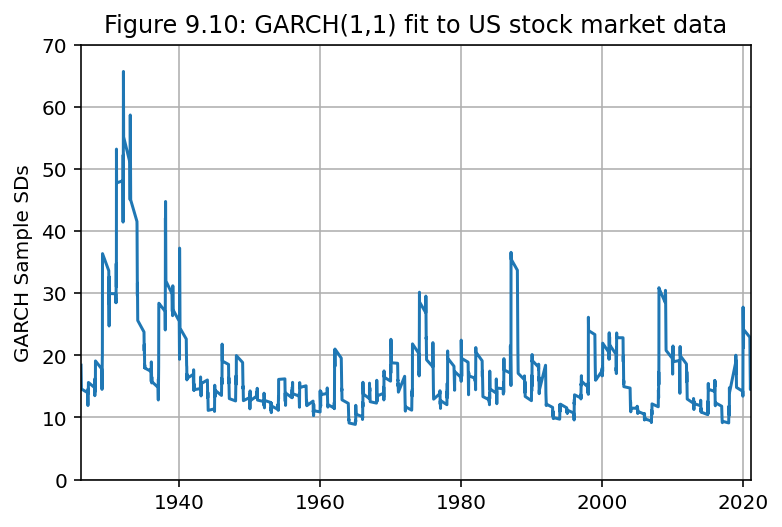

Annual sample std dev 18.417500521661136 = monthly variance of 28.267027122115685 bps
Stationary check (a+b less than one):  0.9819823794165591
Monthly target variance 38.42384433640239 bps
Target annualized standard deviation:  21.472916244349037


In [12]:
#Code Segment 9.11
#fit GARCH(1,1) model
initparams=[.12,.85,.6]
a,b,c=qf.Garch11Fit(initparams,ActualReality)

#Display results
print("a=%.3f" % a)
print("b=%.3f" % b)
print("c=%.3f" % c)

#Draw graph
t=len(ActualReality)
minimal=10**(-20)
stdgarch=np.zeros(t)
stdgarch[0]=np.std(ActualReality)
overallmean=np.mean(ActualReality)
degarched=np.zeros(t)   #series to hold de-garched series y[t]/sigma[t]
degarched[0]=(ActualReality[0]-overallmean)/stdgarch[0]
#Compute GARCH(1,1) stddev's from data given parameters
for i in range(1,t):
    #Note offset - i-1 observation of data
    #is used for i estimate of std deviation
    previous=stdgarch[i-1]**2
    var=c+b*previous+\
        a*(ActualReality[i-1]-overallmean)**2
    stdgarch[i]=np.sqrt(var)
    degarched[i]=(ActualReality[i]-overallmean)/stdgarch[i]

#Annualize
stdgarch*=np.sqrt(12)

#Just show years
Year=[d/100 for d in Date]
    
plt.plot(Year,stdgarch)
plt.grid()
plt.title('Figure 9.10: GARCH(1,1) fit to US stock market data')
plt.ylabel('GARCH Sample SDs')
plt.axis([min(Year),max(Year),0,70])
plt.show();

print("Annual sample std dev",targetsd*np.sqrt(12),"= monthly variance of", \
      targetsd**2,"bps")
print("Stationary check (a+b less than one): ",a+b)
print("Monthly target variance",c/(1-a-b),"bps")
print("Target annualized standard deviation: ",np.sqrt(12*c/(1-a-b)))

## Code segment 9.12  
Excess kurtosis calculation in Section 9.5

In [13]:
#Code Segment 9.12
#Compute before and after excess kurtosis
from scipy import stats
kurt_orig=stats.kurtosis(ActualReality,fisher=True)
kurt_degarch=stats.kurtosis(degarched,fisher=True)
print("Excess kurtois before and after deGarching:", \
      kurt_orig,kurt_degarch)

Excess kurtois before and after deGarching: 6.72850205197582 2.3146623090074856


## Code segment 9.13  
Figure 9.11 in Section 9.5.1
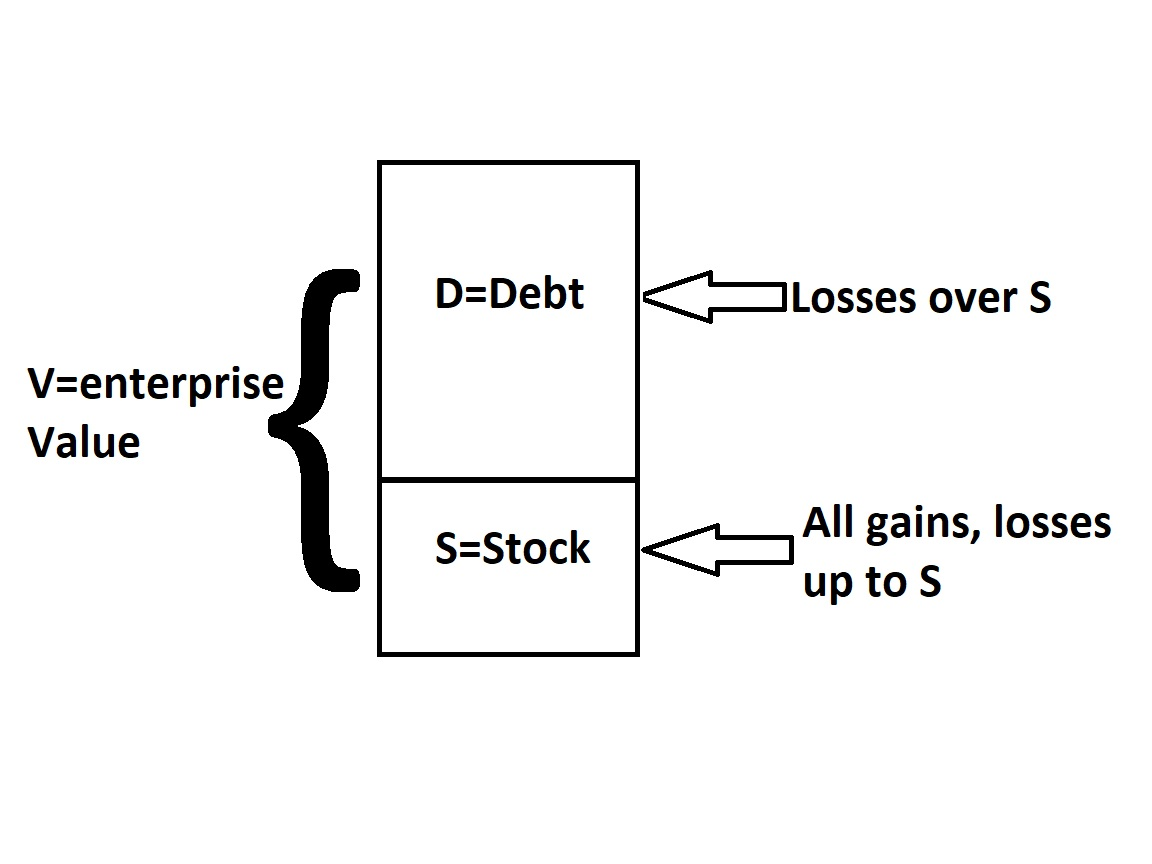

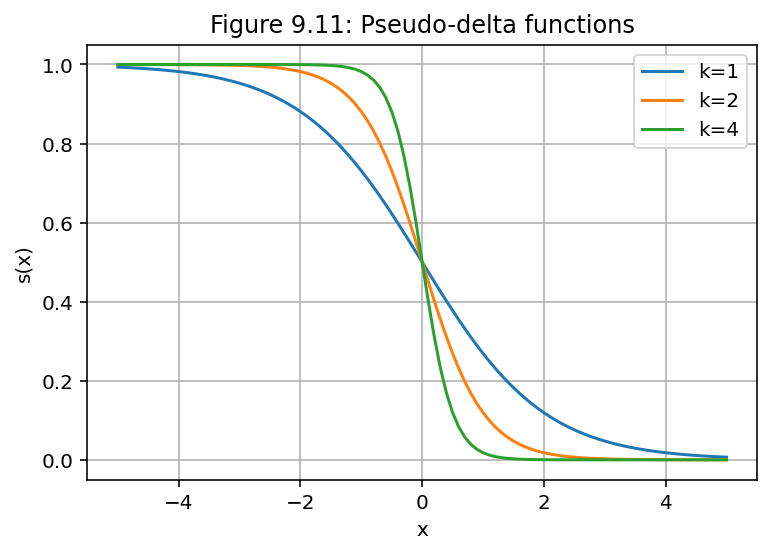

In [14]:
#Code Segment 9.13
#Draw graph of pseudo-delta functions
xs=np.arange(-5,5.1,.1)

for k in [1,2,4]:
    ys=[1/(1+np.exp(k*x)) for x in xs]
    plt.plot(xs,ys,label='k='+str(k))

plt.legend()
plt.xlabel("x")
plt.ylabel("s(x)")
plt.title('Figure 9.11: Pseudo-delta functions')
plt.grid()
plt.show()